# ADME Description & Data Curation

### Dataset description:
The dataset comprises 3521 compounds encompassing six ADME in vitro assays, including endpoints for microsomal stability, plasma protein binding, permeability, and solubility.

**Publication of the dataset**: \
  Prospective Validation of Machine Learning Algorithms for Absorption, Distribution, Metabolism, and Excretion Prediction: An Industrial Perspective \
**DOI**: https://doi.org/10.1021/acs.jcim.3c00160 \
**Github**: https://github.com/molecularinformatics/Computational-ADME

**Published HLM and RLM dataset**: \
https://github.com/molecularinformatics/Computational-ADME/blob/main/ADME_public_set_3521.csv \
Endpoint columns:
- Microsomal stability:  `LOG HLM_CLint (mL/min/kg)`, `LOG RLM_CLint (mL/min/kg)`
- Plasma protein binding: `LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)`, `LOG PLASMA PROTEIN BINDING (RAT) (% unbound)`
- Permeability: `LOG MDR1-MDCK ER (B-A/A-B)`
- Solubility: `LOG SOLUBILITY PH 6.8 (ug/mL)`

- **Tags:** `ADME`, `Lead Optmization`
- **Modalities**: `molecule`
- **Associated benchmarks**:
 - Single tasks:
   - `singletask_LOG_HLM_CLint_fang2023_split`:'gs://polaris-private/benchmarks/ADME/fang2023/fang2023_split/LOG_HLM_CLint/benchmark.json'
   - `singletask_LOG_RLM_CLint_fang2023_split`:'gs://polaris-private/benchmarks/ADME/fang2023/fang2023_split/LOG_RLM_CLint/benchmark.json'
   - `singletask_LOG_MDR1-MDCK_ER_fang2023_split`:'gs://polaris-private/benchmarks/ADME/fang2023/fang2023_split/LOG_MDR1-MDCK_ER/benchmark.json'
   - `singletask_LOG_HPPB_fang2023_split`: 'gs://polaris-private/benchmarks/ADME/fang2023/fang2023_split/LOG_HPPB/benchmark.json'
   - `singletask_LOG_RPPB_fang2023_split`: 'gs://polaris-private/benchmarks/ADME/fang2023/fang2023_split/LOG_RPPB/benchmark.json'
   - `singletask_LOG_SOLUBILITY_fang2023_split`:'gs://polaris-private/benchmarks/ADME/fang2023/fang2023_split/LOG_SOLUBILITY/benchmark.json'
 - Multitask:
   - `multitask_sixADME_random`: 'gs://polaris-private/benchmarks/ADME/fang2023/random/multitask_sixADME/benchmark.json'
   

In [2]:
%load_ext autoreload
%autoreload 2
import datamol as dm
import pandas as pd
from polaris import curation
import os
from os import path
from os.path import dirname
os.chdir(path.dirname(path.dirname(path.abspath("__file__"))))

In [3]:
# load data
data = dm.read_csv(
    "gs://polaris-private/original_datasets/DMPK/Fang2023/ADME_public_set_3521.csv"
)

/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [7]:
# Specify names and extract the test set from their dataset
endpoints = {
    "HLM": "HLM_CLint",
    "RLM": "RLM_CLint",
    "hPPB": "HPPB",
    "rPPB": "RPPB",
    "MDR1_ER": "MDR1-MDCK_ER",
    "Sol": "SOLUBILITY",
}

_endpoint = list(endpoints.keys())
INDIR = "gs://polaris-public/Data/ADME/fang2023/MPNN"

In [9]:
split_key = "fang2023split"
paper_splits = {}
for endpoint in _endpoint:
    testset = dm.read_csv(f"{INDIR}/ADME_{endpoint}_test.csv")
    paper_splits[endpoints[endpoint]] = (
        data.loc[~data.SMILES.isin(testset.smiles)].index.values,
        data.loc[data.SMILES.isin(testset.smiles)].index.values,
    )

In [22]:
testset.smiles.unique().shape

(435,)

In [17]:
data.SMILES.isin(testset.smiles).sum()

400

In [23]:
testset.smiles.isin(data.SMILES).sum()

400

In [5]:
# Define data column names
endpoints = {
    "HLM": "LOG HLM_CLint (mL/min/kg)",
    "RLM": "LOG RLM_CLint (mL/min/kg)",
    "hPPB": "LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)",
    "rPPB": "LOG PLASMA PROTEIN BINDING (RAT) (% unbound)",
    "MDR1_ER": "LOG MDR1-MDCK ER (B-A/A-B)",
    "Sol": "LOG SOLUBILITY PH 6.8 (ug/mL)",
}
data_cols = list(endpoints.values())
mol_col = "SMILES"

In [6]:
data.describe()[data_cols]

,LOG HLM_CLint (mL/min/kg),LOG RLM_CLint (mL/min/kg),LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound),LOG PLASMA PROTEIN BINDING (RAT) (% unbound),LOG MDR1-MDCK ER (B-A/A-B),LOG SOLUBILITY PH 6.8 (ug/mL)
count,3087.000000,3054.000000,194.000000,168.000000,2642.000000,2173.000000
mean,1.320019,2.256207,0.765722,0.764177,0.397829,1.259943
std,0.623952,0.750422,0.847902,0.798988,0.688465,0.683416
min,0.675687,1.027920,-1.593460,-1.638272,-1.162425,-1.000000
25%,0.675687,1.688291,0.168067,0.226564,-0.162356,1.153510
50%,1.205313,2.311068,0.867555,0.776427,0.153291,1.542825
75%,1.803115,2.835274,1.501953,1.375962,0.905013,1.687351
max,3.372714,3.969622,2.000000,2.000000,2.725057,2.179264


array([[<Axes: title={'center': 'LOG HLM_CLint (mL/min/kg)'}>,
        <Axes: title={'center': 'LOG RLM_CLint (mL/min/kg)'}>],
       [<Axes: title={'center': 'LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)'}>,
        <Axes: title={'center': 'LOG PLASMA PROTEIN BINDING (RAT) (% unbound)'}>],
       [<Axes: title={'center': 'LOG MDR1-MDCK ER (B-A/A-B)'}>,
        <Axes: title={'center': 'LOG SOLUBILITY PH 6.8 (ug/mL)'}>]],
      dtype=object)

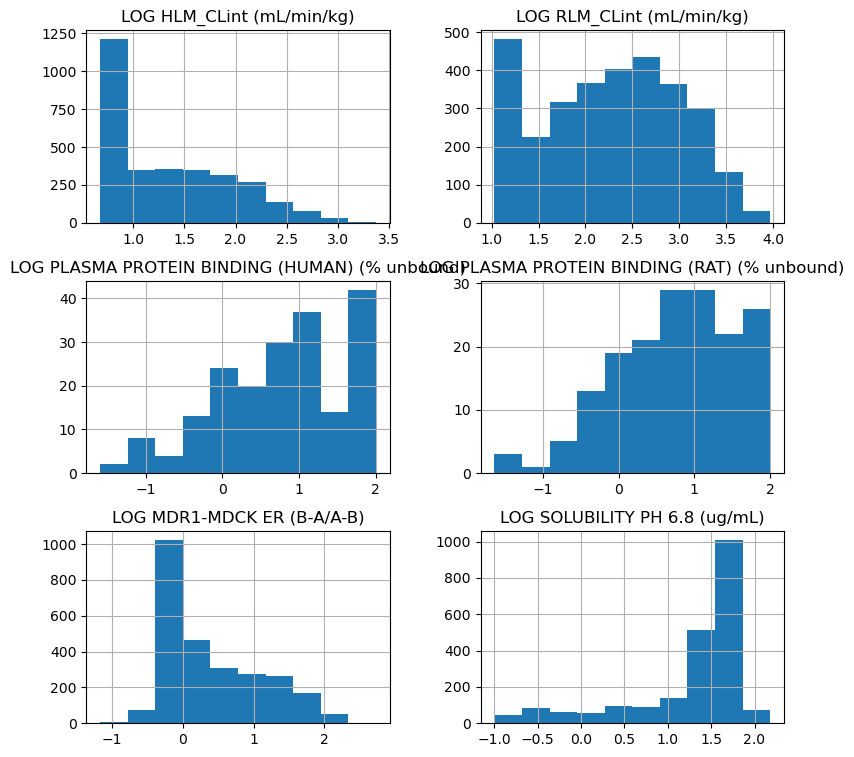

In [9]:
data[data_cols].hist(figsize=(9,9))

### Perform data curation with `polaris.curation` module

In [10]:
# curate
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=True,
    class_thresholds=None
)
df_full = curator_with_stereo()

2023-09-22 13:16:28.341 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 3 outliers for data column LOG HLM_CLint (mL/min/kg) using zscore. Please revise the data and consider remove the outliers. 
2023-09-22 13:16:28.343 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column LOG PLASMA PROTEIN BINDING (RAT) (% unbound) using zscore. Please revise the data and consider remove the outliers. 
2023-09-22 13:16:28.344 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column LOG MDR1-MDCK ER (B-A/A-B) using zscore. Please revise the data and consider remove the outliers. 
2023-09-22 13:16:28.345 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 20 outliers for data column LOG SOLUBILITY PH 6.8 (ug/mL) using zscore. Please revise the data and consider remove the outliers. 
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.

In [18]:
outlier_cols = []
for data_col in data_cols:
    to_plot = df_full.query(f'`OUTLIER_{data_col}` ==True')
    if to_plot.shape[0] > 0:
        outlier_cols.append(data_col)
        display(to_plot[data_cols])

,LOG HLM_CLint (mL/min/kg),LOG RLM_CLint (mL/min/kg),LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound),LOG PLASMA PROTEIN BINDING (RAT) (% unbound),LOG MDR1-MDCK ER (B-A/A-B),LOG SOLUBILITY PH 6.8 (ug/mL)
594,3.339893,3.604436,NaN,NaN,0.178072,1.67071
2784,3.372714,3.495299,NaN,NaN,NaN,NaN
3406,3.328241,3.626562,NaN,NaN,-0.059773,1.40824


,LOG HLM_CLint (mL/min/kg),LOG RLM_CLint (mL/min/kg),LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound),LOG PLASMA PROTEIN BINDING (RAT) (% unbound),LOG MDR1-MDCK ER (B-A/A-B),LOG SOLUBILITY PH 6.8 (ug/mL)
1184,1.284273,2.484587,-1.180456,-1.638272,1.836054,NaN


,LOG HLM_CLint (mL/min/kg),LOG RLM_CLint (mL/min/kg),LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound),LOG PLASMA PROTEIN BINDING (RAT) (% unbound),LOG MDR1-MDCK ER (B-A/A-B),LOG SOLUBILITY PH 6.8 (ug/mL)
3085,1.985754,2.883853,NaN,NaN,2.725057,NaN


,LOG HLM_CLint (mL/min/kg),LOG RLM_CLint (mL/min/kg),LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound),LOG PLASMA PROTEIN BINDING (RAT) (% unbound),LOG MDR1-MDCK ER (B-A/A-B),LOG SOLUBILITY PH 6.8 (ug/mL)
17,NaN,NaN,NaN,NaN,NaN,-0.823909
160,NaN,NaN,NaN,NaN,NaN,-0.795880
161,NaN,NaN,NaN,NaN,NaN,-0.853872
289,NaN,NaN,NaN,NaN,-1.034437,-0.853872
448,NaN,NaN,NaN,NaN,0.885943,-0.920819
758,NaN,NaN,NaN,NaN,-0.516295,-0.920819
1115,NaN,NaN,NaN,NaN,NaN,-1.000000
1339,NaN,NaN,NaN,NaN,NaN,-0.823909
1505,NaN,NaN,NaN,NaN,-0.333575,-0.823909
1530,NaN,NaN,NaN,NaN,-0.313073,-0.853872


The curation raised warning for potential outliers from the bioactivity readouts 'LOG HLM_CLint (mL/min/kg)'. The outlier labels are added in the curated output.  It's important to revise those data points and verify whether they are real outliers and should be removed from the dataset. 

We can also use other outlier detection methods by passing parameters to `outlier_params`. Please see more details in `polaris.curation.utils.outlier_detection`. 

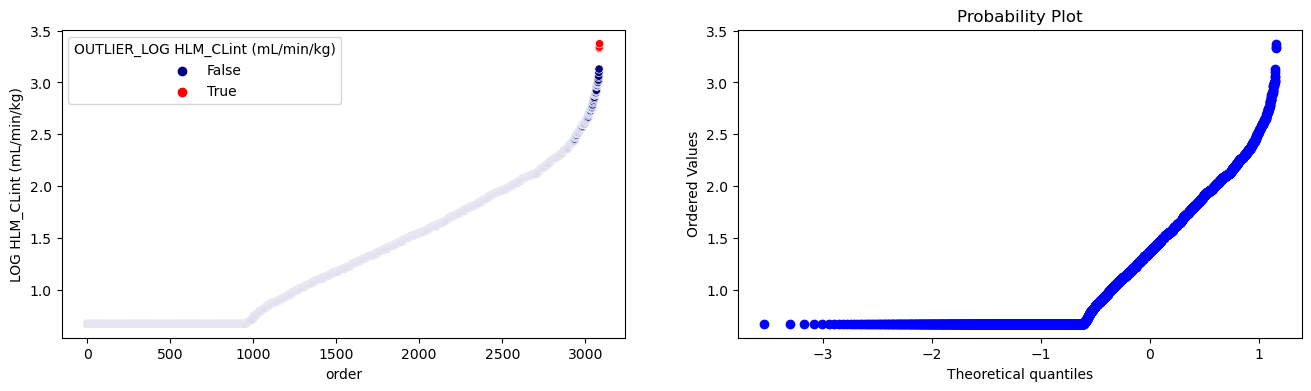

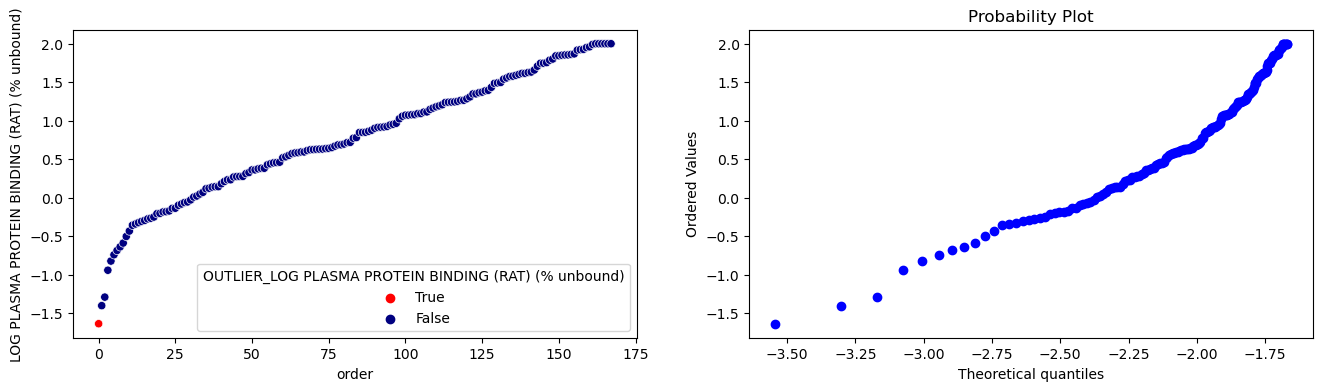

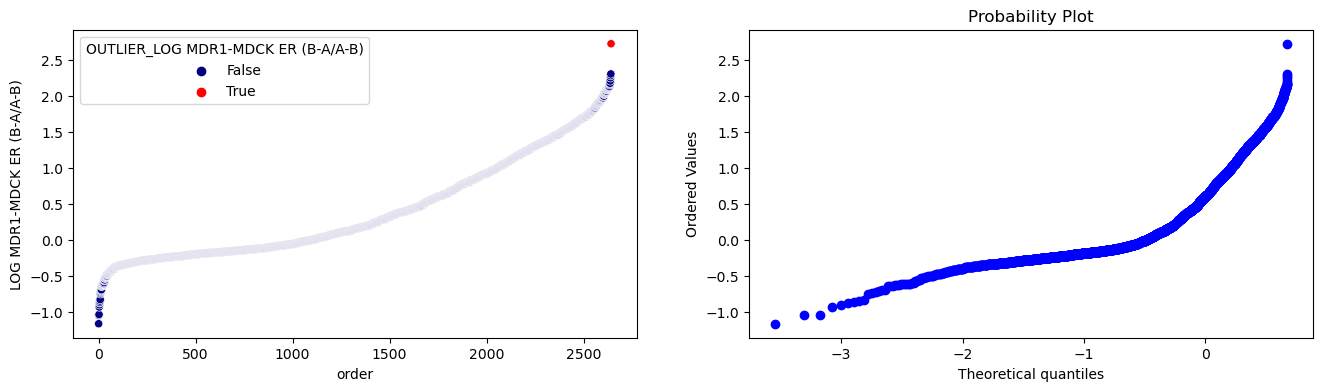

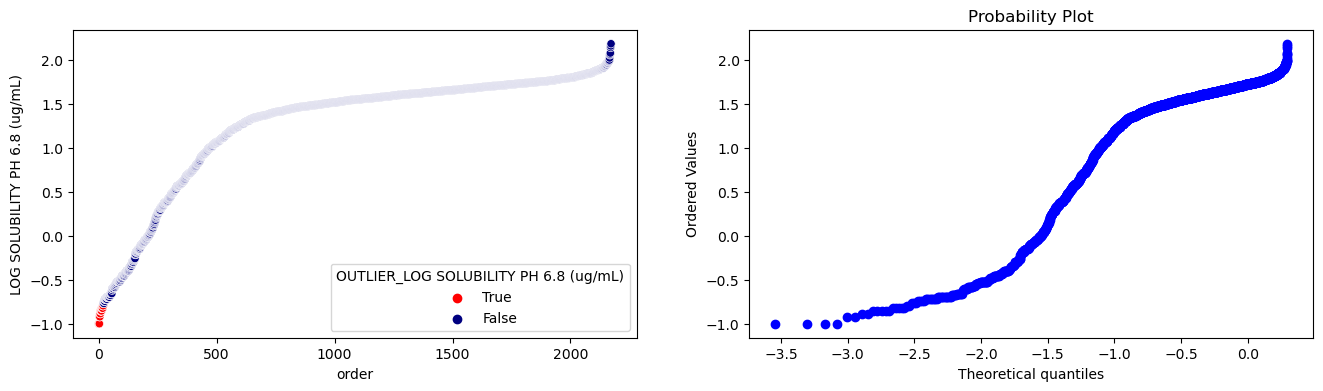

In [21]:
from utils import show_outliers
show_outliers(data=df_full, data_cols=outlier_cols)

The flagged outliers are likely false outliers as they are located on the terminals of the data distributions. 

### Check the compounds with undisered characters

In [22]:
from utils import basic_filter

In [23]:
processed_df = basic_filter(data = df_full, mol_col='smiles')

Filter by rules:   0%|          | 0/3521 [00:00<?, ?it/s]

In [24]:
assert processed_df[processed_df.HasUndesiredEle].shape[0] == 0

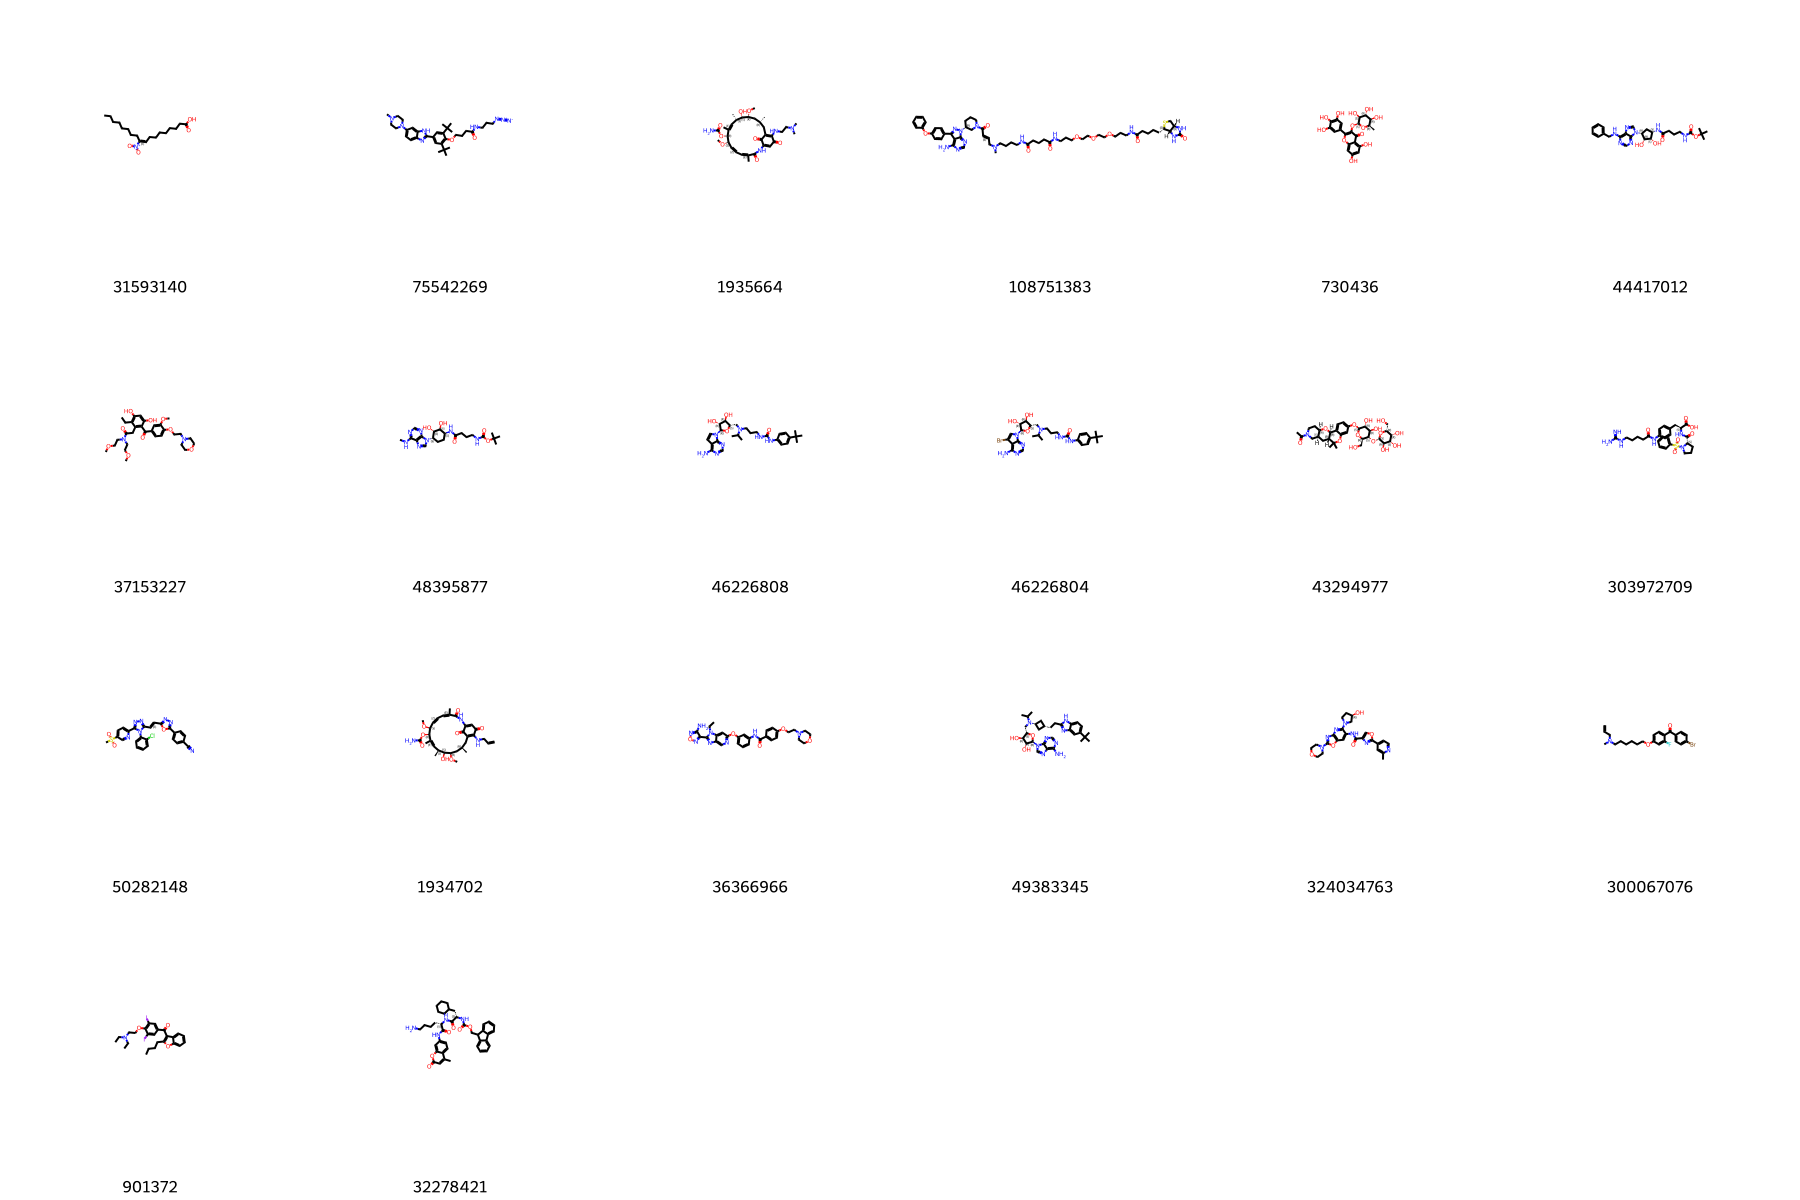

In [25]:
# visualize molecules which don't pass any of the nibr filters.
id_col = "Vendor ID"
to_plot = processed_df[~processed_df.pass_any]
legends=to_plot[id_col].astype(str).tolist()
dm.to_image(to_plot['mol'].tolist(), 
            legends=legends, legendFraction=0.1,
            use_svg=True, n_cols=6)

NIBR filters are intended for molecule prioritization in the context of screening. \
Here we used to flag the molecules which are potentially undesired for the benchmark.\
From above, we can clearly see that molecule 1935664, 1934702, 108751383, 730436, 43294977. 

Molecule 1935664, 1934702 are cyclic peptides. 
Molecule 108751383 is a PROTAC molecule. 
Molecule 730436, 43294977 contains too many hydroxyl groups. 

Here we remove the above molecules from the dataset. 

In [26]:
df_full = df_full.query(f"`{id_col}` not in  ['1935664', '1934702', '108751383', '730436', '43294977'] ")

## Chemical space

In [27]:
mols = df_full.smiles.apply(dm.to_mol)
features = [dm.to_fp(mol) for mol in mols]

In [32]:
import umap
embedding = umap.UMAP().fit_transform(features)
df_full["UMAP_0"], df_full["UMAP_1"] = embedding[:, 0], embedding[:, 1]

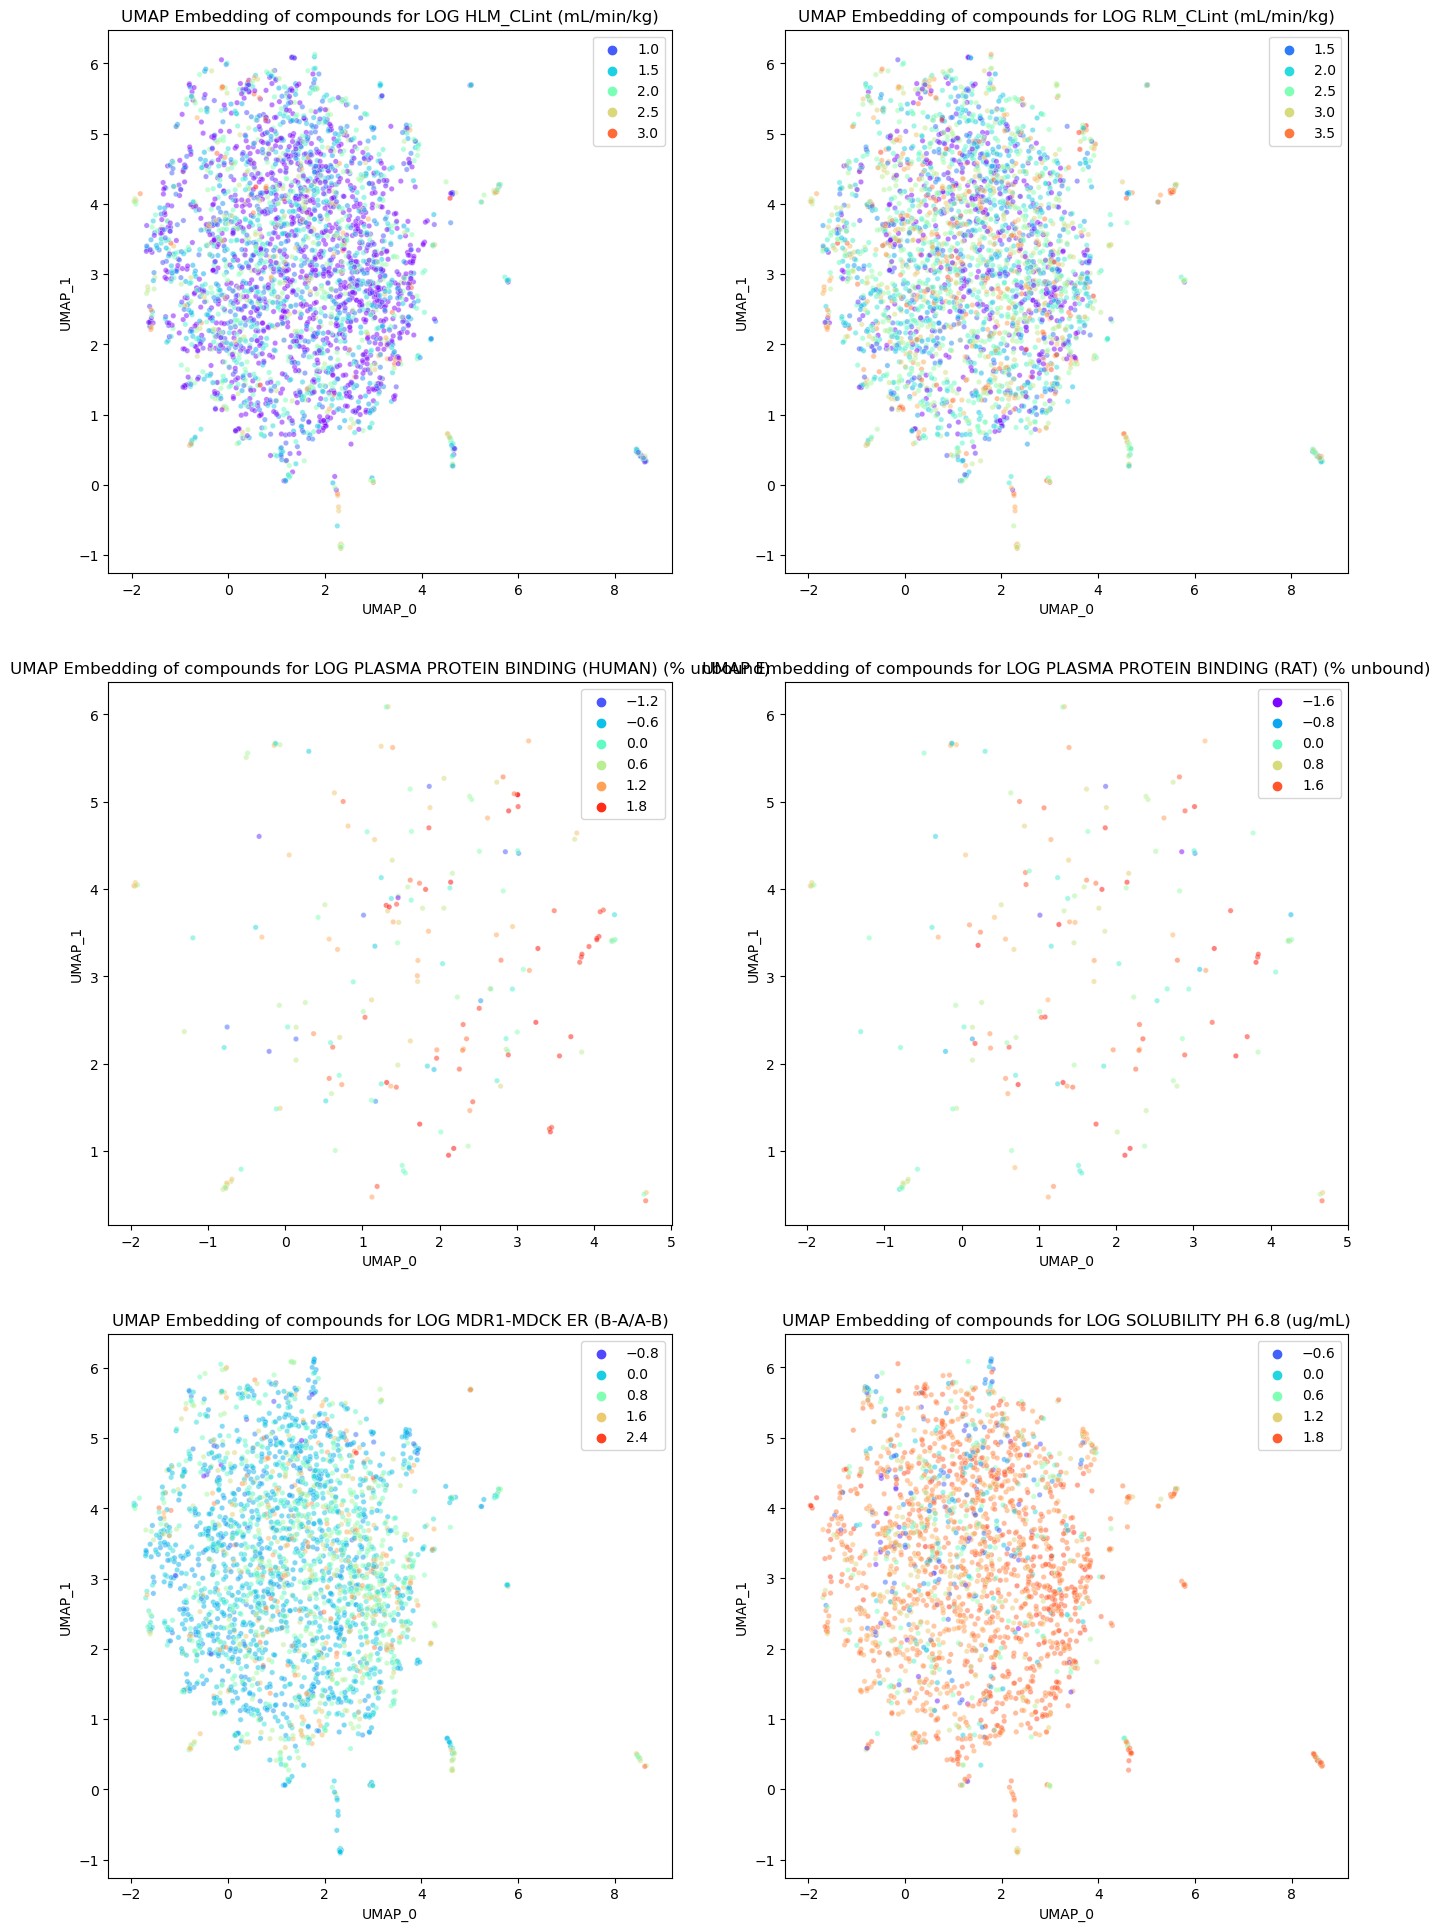

In [40]:
import seaborn as sns
method = "UMAP"
from matplotlib import pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16, 8*3))
axes = axes.flatten()
for i, col in enumerate(data_cols):
    sns.scatterplot(
        data=df_full,
        x="UMAP_0",
        y="UMAP_1",
        alpha=0.5,
        palette="rainbow",
        hue=df_full[data_cols[i]].values,
        ax=axes[i],
        s=15,
    )
    axes[i].set_title(f"{method} Embedding of compounds for {col}")

The distribution of molecules in the chemical space show rather diverse chemistry. 

**Export curated data**

In [43]:
fout = 'gs://polaris-private/curated_datasets/ADME/fang2023_public_set_3521_curated.csv'
df_full.to_csv(fout, index=False)